# Visual Stimuli Analysis (Looming)

This notebook demonstrates how to analyze fly responses to visual stimuli,
particularly looming stimuli that simulate approaching objects.

## Overview

Visual stimuli experiments present expanding discs (looming) to flies during free flight.
Key stimulus parameters include:
- **l/v ratio**: Size-to-velocity ratio (ms) - controls apparent approach speed
- **expansion_duration_ms**: How long the expansion lasts
- **initial/final_size_deg**: Start and end size of the stimulus
- **stimulus_offset_deg**: Angular offset from fly's heading

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import braidz_analysis as ba

print(f"braidz_analysis version: {ba.__version__}")

braidz_analysis version: 0.3.0


## 1. Load Data

Load a .braidz file containing visual stimulus data. The `stim` attribute
will contain the stimulus events with their parameters.

In [2]:
# Load your .braidz file
files = [
    "/mnt/data/experiments/20260115_171408.braidz",
    "/mnt/data/experiments/20260117_125304.braidz",
]
data = ba.read_braidz(files)

# For this example, we'll show the expected structure
# Uncomment and modify the path above for your data

# Example: Check what's in the data
print(f"Trajectories: {len(data.trajectories)} rows")
print(f"Stimuli: {len(data.stim)} events")

2026-01-19 10:51:40,248 [ERROR] Invalid ZIP file: /mnt/data/experiments/20260115_171408.braidz


2026-01-19 10:52:05,882 [WARNING] Skipped 1 file(s) due to errors


Trajectories: 7124361 rows
Stimuli: 272 events


## 2. Explore Stimulus Metadata

The visual_stimuli.csv contains rich metadata about each stimulus presentation.

In [3]:
# Expected columns in visual_stimuli.csv:
stim_columns = [
    "timestamp",  # When stimulus was triggered
    "obj_id",  # Fly ID
    "frame",  # Frame number
    "braid_timestamp",  # Braid system timestamp
    "trigger_timestamp",  # Trigger timestamp
    "stimulus_type",  # Type of stimulus (e.g., 'looming')
    "fly_heading_rad",  # Fly heading at stimulus onset (radians)
    "fly_heading_deg",  # Fly heading at stimulus onset (degrees)
    "stimulus_offset_deg",  # Angular offset from fly heading
    "stimulus_absolute_angle_deg",  # Absolute position of stimulus
    "pixel_x",
    "pixel_y",  # Stimulus position on screen
    "initial_size_deg",  # Starting size of looming disc
    "final_size_deg",  # Final size of looming disc
    "expansion_duration_ms",  # Duration of expansion
    "hold_time_ms",  # Time held at final size
    "expansion_type",  # Type of expansion (linear, exponential)
    "lv_ratio_ms",  # l/v ratio in ms (key parameter!)
    "circle_color",  # Color of the stimulus
]

print("Stimulus metadata columns:")
for col in stim_columns:
    print(f"  - {col}")

Stimulus metadata columns:
  - timestamp
  - obj_id
  - frame
  - braid_timestamp
  - trigger_timestamp
  - stimulus_type
  - fly_heading_rad
  - fly_heading_deg
  - stimulus_offset_deg
  - stimulus_absolute_angle_deg
  - pixel_x
  - pixel_y
  - initial_size_deg
  - final_size_deg
  - expansion_duration_ms
  - hold_time_ms
  - expansion_type
  - lv_ratio_ms
  - circle_color


In [4]:
# Explore stimulus parameters in your data
stim = data.stim

print("Stimulus parameter ranges:")
print(f"  l/v ratios: {stim['lv_ratio_ms'].unique()}")
print(f"  Expansion durations: {stim['expansion_duration_ms'].unique()}")
print(f"  Stimulus offsets: {stim['stimulus_offset_deg'].min():.0f} to {stim['stimulus_offset_deg'].max():.0f} deg")
print(f"  Stimulus types: {stim['stimulus_type'].unique()}")

Stimulus parameter ranges:
  l/v ratios: [25.]
  Expansion durations: [300]
  Stimulus offsets: -90 to 90 deg
  Stimulus types: ['looming']


## 3. Configure Analysis

Visual stimuli typically require a longer response window than optogenetic stimuli,
since the behavioral response may be delayed relative to stimulus onset.

In [6]:
# Use the pre-configured STIM_CONFIG or create a custom one
from braidz_analysis.config import STIM_CONFIG, Config

print("STIM_CONFIG settings:")
print(f"  response_window: {STIM_CONFIG.response_window} frames")
print(f"  pre_frames: {STIM_CONFIG.pre_frames} frames")
print(f"  post_frames: {STIM_CONFIG.post_frames} frames")
print(f"  saccade_threshold: {STIM_CONFIG.saccade_threshold} deg/s")

# Or create a custom config for your specific experiment
custom_config = Config(
    response_window=60,  # 600ms at 100fps - longer window for visual responses
    pre_frames=50,  # 500ms before stimulus
    post_frames=150,  # 1500ms after stimulus
    saccade_threshold=300,  # deg/s threshold for turn detection
    min_trajectory_frames=250,  # Must accommodate pre+post frames
)

STIM_CONFIG settings:
  response_window: 50 frames
  pre_frames: 50 frames
  post_frames: 150 frames
  saccade_threshold: 300.0 deg/s


## 4. Run Analysis

Use `analyze_event_responses` with the stimulus data. All stimulus metadata
will be preserved in the results for filtering and grouping.

In [7]:
# Run the analysis
results = ba.analyze_event_responses(
    data.trajectories,
    data.stim,
    config=STIM_CONFIG
)

print(results)
print(f"Overall response rate: {results.response_rate:.1%}")

  0%|          | 0/272 [00:00<?, ?it/s]

100%|██████████| 272/272 [00:06<00:00, 40.62it/s]

EventResults(117 events, 82 responses)
Overall response rate: 70.1%


In [8]:
# Check available metadata columns
print("Metadata columns preserved:")
print(results.metadata.columns.tolist())

Metadata columns preserved:
['timestamp', 'braid_timestamp', 'trigger_timestamp', 'stimulus_type', 'fly_heading_rad', 'fly_heading_deg', 'stimulus_offset_deg', 'stimulus_absolute_angle_deg', 'pixel_x', 'pixel_y', 'initial_size_deg', 'final_size_deg', 'expansion_duration_ms', 'hold_time_ms', 'expansion_type', 'lv_ratio_ms', 'circle_color']


## 5. Filter by Stimulus Parameters

The `filter()` method works with both metrics and metadata columns.

In [ ]:
# Filter by l/v ratio
# lv_10 = results.filter(lv_ratio_ms=10)
# lv_40 = results.filter(lv_ratio_ms=40)
#
# print(f"l/v = 10ms: {len(lv_10)} trials, {lv_10.response_rate:.1%} response rate")
# print(f"l/v = 40ms: {len(lv_40)} trials, {lv_40.response_rate:.1%} response rate")

In [9]:
# Filter by stimulus position (frontal vs lateral)
frontal = results.filter(
    mask=np.abs(results.metadata['stimulus_offset_deg']) < 45
)
lateral = results.filter(
    mask=np.abs(results.metadata['stimulus_offset_deg']) >= 45
)

print(f"Frontal stimuli: {frontal.response_rate:.1%} response rate")
print(f"Lateral stimuli: {lateral.response_rate:.1%} response rate")

Frontal stimuli: 73.7% response rate
Lateral stimuli: 68.4% response rate


In [10]:
# Get responsive vs non-responsive trials
responsive = results.responsive
non_responsive = results.non_responsive

print(f"Responsive: {len(responsive)} trials")
print(f"Non-responsive: {len(non_responsive)} trials")

Responsive: 82 trials
Non-responsive: 35 trials


## 6. Compare Response Rates Across Conditions

Analyze how response rates vary with stimulus parameters.

In [11]:
# Compare response rates by l/v ratio
# lv_ratios = results.metadata['lv_ratio_ms'].unique()
#
# print("Response rate by l/v ratio:")
# for lv in sorted(lv_ratios):
#     subset = results.filter(lv_ratio_ms=lv)
#     print(f"  l/v = {lv:3.0f} ms: {subset.response_rate:5.1%} ({len(subset)} trials)")

In [12]:
# Use compute_response_statistics for automatic grouping
stats = ba.compute_response_statistics(results)
print(stats)

  stimulus_type  stimulus_offset_deg  pixel_y  initial_size_deg  \
0       looming                  -90      540               5.0   
1       looming                    0      540               5.0   
2       looming                   90      540               5.0   

   final_size_deg  expansion_duration_ms  hold_time_ms expansion_type  \
0            45.0                    300           200    exponential   
1            45.0                    300           200    exponential   
2            45.0                    300           200    exponential   

   lv_ratio_ms circle_color  n_events  n_responses  response_rate  \
0         25.0    (0, 0, 0)        38           26       0.684211   
1         25.0    (0, 0, 0)        38           28       0.736842   
2         25.0    (0, 0, 0)        41           28       0.682927   

   mean_heading_change  mean_reaction_time  
0              1.38625           22.961538  
1              1.92121           24.392857  
2              1.40984    

In [ ]:
# Plot response rate by l/v ratio
# fig, ax = plt.subplots(figsize=(8, 5))
#
# lv_stats = []
# for lv in sorted(results.metadata['lv_ratio_ms'].unique()):
#     subset = results.filter(lv_ratio_ms=lv)
#     lv_stats.append({
#         'lv_ratio': lv,
#         'response_rate': subset.response_rate,
#         'n_trials': len(subset)
#     })
#
# lv_df = pd.DataFrame(lv_stats)
# ax.bar(lv_df['lv_ratio'].astype(str), lv_df['response_rate'])
# ax.set_xlabel('l/v ratio (ms)')
# ax.set_ylabel('Response rate')
# ax.set_title('Response Rate by Looming Speed')
# ax.set_ylim(0, 1)
#
# # Add trial counts
# for i, row in lv_df.iterrows():
#     ax.annotate(f'n={row["n_trials"]}',
#                 xy=(i, row['response_rate']),
#                 ha='center', va='bottom')
#
# plt.tight_layout()
# plt.show()

## 7. Plot Traces

Visualize angular velocity traces aligned to stimulus onset.

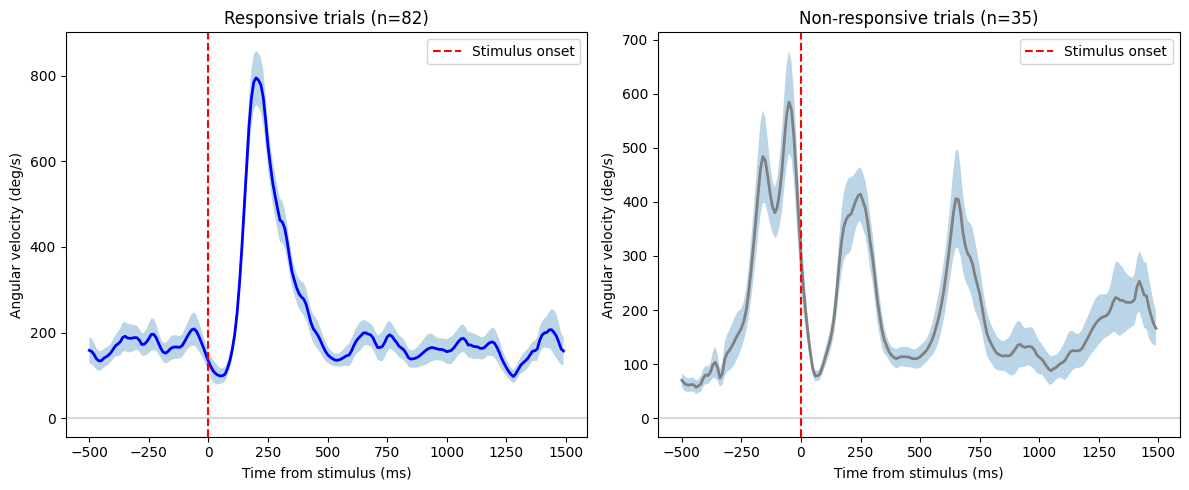

In [ ]:
# Plot mean angular velocity traces
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Time axis (centered on stimulus onset)
t = np.arange(-STIM_CONFIG.pre_frames, STIM_CONFIG.post_frames) / STIM_CONFIG.fps * 1000

# Responsive trials
# TODO: Plot responsive mean for each `stimulus_offset_deg` 
responsive_traces_abs = np.abs(responsive.traces['angular_velocity'])
ax = axes[0]
if len(responsive) > 0:
    omega = np.degrees(responsive_traces_abs)  # Convert to deg/s
    mean_omega = np.mean(omega, axis=0)
    sem_omega = np.std(omega, axis=0) / np.sqrt(len(omega))

    ax.fill_between(t, mean_omega - sem_omega, mean_omega + sem_omega, alpha=0.3)
    ax.plot(t, mean_omega, 'b-', linewidth=2)

ax.axvline(0, color='r', linestyle='--', label='Stimulus onset')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Time from stimulus (ms)')
ax.set_ylabel('Angular velocity (deg/s)')
ax.set_title(f'Responsive trials (n={len(responsive)})')
ax.legend()

# Non-responsive trials
non_responsive_traces_abs = np.abs(non_responsive.traces['angular_velocity'])
ax = axes[1]
if len(non_responsive) > 0:
    omega = np.degrees(non_responsive_traces_abs)
    mean_omega = np.mean(omega, axis=0)
    sem_omega = np.std(omega, axis=0) / np.sqrt(len(omega))

    ax.fill_between(t, mean_omega - sem_omega, mean_omega + sem_omega, alpha=0.3)
    ax.plot(t, mean_omega, 'gray', linewidth=2)

ax.axvline(0, color='r', linestyle='--', label='Stimulus onset')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Time from stimulus (ms)')
ax.set_ylabel('Angular velocity (deg/s)')
ax.set_title(f'Non-responsive trials (n={len(non_responsive)})')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Plot mean and std traces grouped by stimulus_offset_deg
fig, ax = plt.subplots(figsize=(10, 6))

# Time axis (centered on stimulus onset)
t = np.arange(-STIM_CONFIG.pre_frames, STIM_CONFIG.post_frames) / STIM_CONFIG.fps * 1000

# Get unique stimulus offsets
offsets = sorted(results.metadata['stimulus_offset_deg'].unique())
colors = plt.cm.coolwarm(np.linspace(0, 1, len(offsets)))

for offset, color in zip(offsets, colors):
    subset = results.filter(stimulus_offset_deg=offset)
    if len(subset) > 0:
        # Use absolute angular velocity for magnitude comparison
        omega = np.degrees(np.abs(subset.traces['angular_velocity']))
        mean_omega = np.mean(omega, axis=0)
        std_omega = np.std(omega, axis=0)
        
        ax.fill_between(t, mean_omega - std_omega, mean_omega + std_omega, 
                        alpha=0.2, color=color)
        ax.plot(t, mean_omega, color=color, linewidth=2, 
                label=f'{offset:+.0f}° (n={len(subset)})')

ax.axvline(0, color='k', linestyle='--', alpha=0.5, label='Stimulus onset')
ax.axhline(STIM_CONFIG.saccade_threshold, color='gray', linestyle=':', 
           alpha=0.5, label=f'Threshold ({STIM_CONFIG.saccade_threshold}°/s)')
ax.set_xlabel('Time from stimulus (ms)')
ax.set_ylabel('|Angular velocity| (deg/s)')
ax.set_title('Response by Stimulus Offset')
ax.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Compare traces by l/v ratio
# fig, ax = plt.subplots(figsize=(10, 6))
#
# colors = plt.cm.viridis(np.linspace(0, 0.8, len(lv_ratios)))
#
# for lv, color in zip(sorted(lv_ratios), colors):
#     subset = results.filter(lv_ratio_ms=lv)
#     if len(subset) > 0:
#         omega = np.degrees(subset.traces['angular_velocity'])
#         mean_omega = np.mean(np.abs(omega), axis=0)  # Absolute value for comparison
#         ax.plot(t, mean_omega, color=color, linewidth=2,
#                 label=f'l/v={lv}ms (n={len(subset)})')
#
# ax.axvline(0, color='r', linestyle='--', alpha=0.5)
# ax.set_xlabel('Time from stimulus (ms)')
# ax.set_ylabel('|Angular velocity| (deg/s)')
# ax.set_title('Response magnitude by looming speed')
# ax.legend()
#
# plt.tight_layout()
# plt.show()

## 8. Analyze Response Metrics

Compare heading changes and reaction times across conditions.

In [ ]:
# Reaction time distribution
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))
#
# # Reaction time histogram
# ax = axes[0]
# rt = responsive.metrics['reaction_time'] / STIM_CONFIG.fps * 1000  # Convert to ms
# ax.hist(rt.dropna(), bins=20, edgecolor='black')
# ax.axvline(rt.median(), color='r', linestyle='--', label=f'Median: {rt.median():.0f} ms')
# ax.set_xlabel('Reaction time (ms)')
# ax.set_ylabel('Count')
# ax.set_title('Reaction Time Distribution')
# ax.legend()
#
# # Heading change distribution
# ax = axes[1]
# hc = np.degrees(responsive.metrics['heading_change'])  # Convert to degrees
# ax.hist(hc.dropna(), bins=20, edgecolor='black')
# ax.axvline(0, color='gray', linestyle='-', alpha=0.5)
# ax.set_xlabel('Heading change (deg)')
# ax.set_ylabel('Count')
# ax.set_title('Heading Change Distribution')
#
# plt.tight_layout()
# plt.show()

In [ ]:
# Heading change vs stimulus offset (do flies turn away from the stimulus?)
# fig, ax = plt.subplots(figsize=(8, 6))
#
# # Combine metrics and metadata for plotting
# plot_df = pd.concat([
#     responsive.metrics[['heading_change']],
#     responsive.metadata[['stimulus_offset_deg']]
# ], axis=1)
#
# plot_df['heading_change_deg'] = np.degrees(plot_df['heading_change'])
#
# ax.scatter(plot_df['stimulus_offset_deg'], plot_df['heading_change_deg'], alpha=0.5)
# ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
# ax.axvline(0, color='gray', linestyle='-', alpha=0.3)
#
# # Add regression line
# from scipy import stats
# slope, intercept, r, p, se = stats.linregress(
#     plot_df['stimulus_offset_deg'].dropna(),
#     plot_df['heading_change_deg'].dropna()
# )
# x_line = np.array([-180, 180])
# ax.plot(x_line, slope * x_line + intercept, 'r--',
#         label=f'r={r:.2f}, p={p:.3f}')
#
# ax.set_xlabel('Stimulus offset (deg)')
# ax.set_ylabel('Heading change (deg)')
# ax.set_title('Turn Direction vs Stimulus Position')
# ax.legend()
#
# plt.tight_layout()
# plt.show()

## 9. Compare Responsive vs Non-Responsive Trials

Since v0.3, metrics are computed for all trials (not just responsive ones),
allowing direct comparison.

In [ ]:
# Compare max velocity in window between responsive and non-responsive
# fig, ax = plt.subplots(figsize=(8, 5))
#
# resp_max_vel = np.degrees(responsive.metrics['max_velocity_in_window'])
# non_resp_max_vel = np.degrees(non_responsive.metrics['max_velocity_in_window'])
#
# data_to_plot = [resp_max_vel.dropna(), non_resp_max_vel.dropna()]
# bp = ax.boxplot(data_to_plot, labels=['Responsive', 'Non-responsive'])
#
# ax.axhline(STIM_CONFIG.saccade_threshold, color='r', linestyle='--',
#            label=f'Threshold: {STIM_CONFIG.saccade_threshold} deg/s')
# ax.set_ylabel('Max |angular velocity| in window (deg/s)')
# ax.set_title('Peak Angular Velocity by Response Status')
# ax.legend()
#
# plt.tight_layout()
# plt.show()

## 10. Export Results

Save analysis results for further processing or publication.

In [ ]:
# Combine metrics and metadata into a single DataFrame
# full_results = pd.concat([results.metrics, results.metadata], axis=1)
#
# # Convert units for readability
# full_results['heading_change_deg'] = np.degrees(full_results['heading_change'])
# full_results['peak_velocity_deg_s'] = np.degrees(full_results['peak_velocity'])
# full_results['max_velocity_deg_s'] = np.degrees(full_results['max_velocity_in_window'])
# full_results['reaction_time_ms'] = full_results['reaction_time'] / STIM_CONFIG.fps * 1000
#
# # Save to CSV
# # full_results.to_csv('visual_stim_results.csv', index=False)
#
# print("Columns in results:")
# print(full_results.columns.tolist())

## Summary

This notebook demonstrated:

1. **Loading data** with `read_braidz()` - automatically extracts visual_stimuli.csv
2. **Exploring metadata** - all stimulus parameters are preserved
3. **Configuring analysis** - use `STIM_CONFIG` or custom `Config`
4. **Running analysis** - `analyze_event_responses()` handles everything
5. **Filtering results** - by any metric or metadata column
6. **Comparing conditions** - response rates by l/v ratio, position, etc.
7. **Plotting traces** - aligned to stimulus onset
8. **Analyzing metrics** - reaction times, heading changes
9. **Responsive vs non-responsive** - metrics available for all trials

Key stimulus parameters to consider:
- `lv_ratio_ms`: Lower values = faster apparent approach = stronger response
- `stimulus_offset_deg`: Position relative to fly's heading
- `expansion_duration_ms`: Total stimulus duration
- `initial_size_deg` / `final_size_deg`: Size change during expansion